# Twitter 2020

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')  # Download the VADER lexicon
import matplotlib.pyplot as plt

import psycopg2
from sqlalchemy import create_engine

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Extract and organize data

In [2]:
# import data
data = pd.read_csv('Twitter/result20200101-20210101.csv',encoding='ISO-8859-1')


In [3]:
# grab fields of interest
# select the columns wanted and rename them
df_selection = data[['create_at', 'geo_tag.stateName', 'user.id', 'text']]
data = df_selection.rename(columns={
    'create_at': 'Created',
    'geo_tag.stateName': 'State',
    'user.id': 'Owner',
    'text': 'Tweet'
})
data
# gives 10363 rows × 4 columns

,Created,State,Owner,Tweet
0,2020-08-01 00:19:13.0,Oregon,1033162882471477248,Not to worry hes already demonstrated hes no...
1,2020-08-01 03:29:02.0,Texas,763513801874419712,@itsJeffTiedrich @realDonaldTrump Please conti...
2,2020-08-01 06:39:15.0,Texas,1153704213236633602,Donny just blows! Testing is done all over < ...
3,2020-08-01 14:19:56.0,Oklahoma,4805323446,@southernwayjim @DineshDSouza USAs 8-year mar...
4,2020-08-01 15:24:36.0,Kentucky,1114258326068629505,All the drive up corona testing and we arent ...
...,...,...,...,...
14057,2020-11-30 18:19:42.0,Oregon,2711106523,@Knighth50350096 @itsJeffTiedrich @realDonaldT...
14058,2020-11-30 19:46:15.0,Washington,1350342876,@neville1776 @KingStonerJ @Faiithe @OneSynical...
14059,2020-11-30 21:59:05.0,Arizona,843513633741008896,@HermanBoone17 @murray_nyc @itsJeffTiedrich @r...
14060,2020-11-30 22:45:58.0,Minnesota,3244707002,"Trump pressures senators, governors, and reps ..."


In [4]:
# convert the states to abbrivations
state_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# Apply the state mapping to convert the state column
data['State'] = data['State'].map(state_mapping)

# Print the updated DataFrame
data

,Created,State,Owner,Tweet
0,2020-08-01 00:19:13.0,OR,1033162882471477248,Not to worry hes already demonstrated hes no...
1,2020-08-01 03:29:02.0,TX,763513801874419712,@itsJeffTiedrich @realDonaldTrump Please conti...
2,2020-08-01 06:39:15.0,TX,1153704213236633602,Donny just blows! Testing is done all over < ...
3,2020-08-01 14:19:56.0,OK,4805323446,@southernwayjim @DineshDSouza USAs 8-year mar...
4,2020-08-01 15:24:36.0,KY,1114258326068629505,All the drive up corona testing and we arent ...
...,...,...,...,...
14057,2020-11-30 18:19:42.0,OR,2711106523,@Knighth50350096 @itsJeffTiedrich @realDonaldT...
14058,2020-11-30 19:46:15.0,WA,1350342876,@neville1776 @KingStonerJ @Faiithe @OneSynical...
14059,2020-11-30 21:59:05.0,AZ,843513633741008896,@HermanBoone17 @murray_nyc @itsJeffTiedrich @r...
14060,2020-11-30 22:45:58.0,MN,3244707002,"Trump pressures senators, governors, and reps ..."


In [5]:
# add year and office columns
data['Year'] = 2020
# Arrange columns: Move the Year and Office columns to the front
new_cols = ['Year', 'Created', 'State', 'Owner', 'Tweet']
data_2020 = data.reindex(columns=new_cols)
data_2020
# gives 10363 rows × 5 columns

,Year,Created,State,Owner,Tweet
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,Not to worry hes already demonstrated hes no...
1,2020,2020-08-01 03:29:02.0,TX,763513801874419712,@itsJeffTiedrich @realDonaldTrump Please conti...
2,2020,2020-08-01 06:39:15.0,TX,1153704213236633602,Donny just blows! Testing is done all over < ...
3,2020,2020-08-01 14:19:56.0,OK,4805323446,@southernwayjim @DineshDSouza USAs 8-year mar...
4,2020,2020-08-01 15:24:36.0,KY,1114258326068629505,All the drive up corona testing and we arent ...
...,...,...,...,...,...
14057,2020,2020-11-30 18:19:42.0,OR,2711106523,@Knighth50350096 @itsJeffTiedrich @realDonaldT...
14058,2020,2020-11-30 19:46:15.0,WA,1350342876,@neville1776 @KingStonerJ @Faiithe @OneSynical...
14059,2020,2020-11-30 21:59:05.0,AZ,843513633741008896,@HermanBoone17 @murray_nyc @itsJeffTiedrich @r...
14060,2020,2020-11-30 22:45:58.0,MN,3244707002,"Trump pressures senators, governors, and reps ..."


In [6]:
# Check for duplicate rows
duplicate_rows = data_2020.duplicated()

# Print the duplicate rows
print(data_2020[duplicate_rows])

       Year                Created State                Owner   
268    2020  2020-08-02 07:31:11.0    NC           2308532982  \
312    2020  2020-08-05 14:39:50.0    FL             20723597   
350    2020  2020-08-07 03:05:33.0    LA   974819385746444288   
355    2020  2020-08-11 15:41:32.0    NV            148558621   
416    2020  2020-08-10 00:28:47.0    CO  1097923385445761027   
...     ...                    ...   ...                  ...   
14035  2020  2020-11-29 11:53:17.0    CT   713107684581588994   
14043  2020  2020-11-29 21:30:33.0    OR             64914137   
14044  2020  2020-11-29 21:57:10.0    FL   825727643958046720   
14056  2020  2020-11-30 15:22:53.0    CA            882699985   
14059  2020  2020-11-30 21:59:05.0    AZ   843513633741008896   

                                                   Tweet  
268    So, apparently God-Like Wï¿½nderkind, most cre...  
312    @JoeBiden @TomAdler Joe, I love your attacks o...  
350    @nhannahjones @10000Votes led by yo

In [7]:
# Remove duplicate rows
data_2020 = data_2020.drop_duplicates()

# Print the DataFrame without duplicates
data_2020
# gives 13559 rows × 5 columns

,Year,Created,State,Owner,Tweet
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,Not to worry hes already demonstrated hes no...
1,2020,2020-08-01 03:29:02.0,TX,763513801874419712,@itsJeffTiedrich @realDonaldTrump Please conti...
2,2020,2020-08-01 06:39:15.0,TX,1153704213236633602,Donny just blows! Testing is done all over < ...
3,2020,2020-08-01 14:19:56.0,OK,4805323446,@southernwayjim @DineshDSouza USAs 8-year mar...
4,2020,2020-08-01 15:24:36.0,KY,1114258326068629505,All the drive up corona testing and we arent ...
...,...,...,...,...,...
14055,2020,2020-11-30 14:13:19.0,IL,801059546886180864,@itsJeffTiedrich @realDonaldTrump Trump did no...
14057,2020,2020-11-30 18:19:42.0,OR,2711106523,@Knighth50350096 @itsJeffTiedrich @realDonaldT...
14058,2020,2020-11-30 19:46:15.0,WA,1350342876,@neville1776 @KingStonerJ @Faiithe @OneSynical...
14060,2020,2020-11-30 22:45:58.0,MN,3244707002,"Trump pressures senators, governors, and reps ..."


# Clean and process data

In [8]:
def trim_length(text):
    '''
    This method removes the repeating characters that are repeated more than 2 times
    '''
    pat = re.compile(r"(.)\1{2,}")
    return pat.sub(r"\1\1", text)

def word_correct(myStr):
    '''
    This method accepts a string and removes the meta characters from it
    '''
    myStr = str(myStr)
    pat = re.compile(r'[^a-zA-Z1-9]+')
    corrected_str = ''
    splits = myStr.split()
    for word in splits:
        word = word.strip()
        word = re.sub(pat, '', word).lower()
        word = trim_length(word)
        corrected_str = corrected_str+word+' '
    corrected_str = corrected_str.strip()
    return corrected_str

def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_word(myStr):
    myStr = str(myStr)
    lemmatizer = WordNetLemmatizer()
    lst_word = nltk.word_tokenize(myStr)
    final_str=''
    for word in lst_word:
        word = lemmatizer.lemmatize(word, get_pos(word))
        final_str = final_str+word+' '

    final_str = final_str.strip()
    return final_str

data_2020['Tweet'] = data_2020['Tweet'].apply(lambda i:word_correct(i))
data_2020['Tweet'] = data_2020['Tweet'].apply(lambda i:lemmatize_word(i))
print('Done')

C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\2534205638.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020['Tweet'] = data_2020['Tweet'].apply(lambda i:word_correct(i))


Done


C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\2534205638.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020['Tweet'] = data_2020['Tweet'].apply(lambda i:lemmatize_word(i))


In [9]:
# view cleaned data
data_2020

,Year,Created,State,Owner,Tweet
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...
1,2020,2020-08-01 03:29:02.0,TX,763513801874419712,itsjefftiedrich realdonaldtrump please continu...
2,2020,2020-08-01 06:39:15.0,TX,1153704213236633602,donny just blow test be do all over he dumbass...
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...
4,2020,2020-08-01 15:24:36.0,KY,1114258326068629505,all the drive up corona test and we arent smar...
...,...,...,...,...,...
14055,2020,2020-11-30 14:13:19.0,IL,801059546886180864,itsjefftiedrich realdonaldtrump trump do not l...
14057,2020,2020-11-30 18:19:42.0,OR,2711106523,knighth53596 itsjefftiedrich realdonaldtrump o...
14058,2020,2020-11-30 19:46:15.0,WA,1350342876,neville1776 kingstonerj faiithe onesynical ell...
14060,2020,2020-11-30 22:45:58.0,MN,3244707002,trump pressure senator governor and rep to pus...


# Abortion Tweets

In [10]:
def extract_abortion_text(df):
    df['Abortion'] = df['Tweet'].str.extract(r'(\b(?:abortion|planned|parenthood|prochoice|pro-choice|prolife|pro-life|reproductiverights|reproductive-rights|right|choose|women\'s|rights|termination|roe|wade|pro-abortion|anti-abortion|fetus|pregnancy|reproductive|healthcare|health|access|ban|debate)\b)', flags=re.IGNORECASE)
    return df

abortion_tweet_2020 = extract_abortion_text(data_2020)
abortion_tweet_2020

C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\2658452145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Abortion'] = df['Tweet'].str.extract(r'(\b(?:abortion|planned|parenthood|prochoice|pro-choice|prolife|pro-life|reproductiverights|reproductive-rights|right|choose|women\'s|rights|termination|roe|wade|pro-abortion|anti-abortion|fetus|pregnancy|reproductive|healthcare|health|access|ban|debate)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...,NaN
1,2020,2020-08-01 03:29:02.0,TX,763513801874419712,itsjefftiedrich realdonaldtrump please continu...,NaN
2,2020,2020-08-01 06:39:15.0,TX,1153704213236633602,donny just blow test be do all over he dumbass...,NaN
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...,NaN
4,2020,2020-08-01 15:24:36.0,KY,1114258326068629505,all the drive up corona test and we arent smar...,NaN
...,...,...,...,...,...,...
14055,2020,2020-11-30 14:13:19.0,IL,801059546886180864,itsjefftiedrich realdonaldtrump trump do not l...,NaN
14057,2020,2020-11-30 18:19:42.0,OR,2711106523,knighth53596 itsjefftiedrich realdonaldtrump o...,NaN
14058,2020,2020-11-30 19:46:15.0,WA,1350342876,neville1776 kingstonerj faiithe onesynical ell...,NaN
14060,2020,2020-11-30 22:45:58.0,MN,3244707002,trump pressure senator governor and rep to pus...,NaN


In [11]:
# remove NaN rows
abortion_2020 = abortion_tweet_2020[abortion_tweet_2020['Abortion'].notna()]
abortion_2020
# gives 1500 rows × 6 columns

,Year,Created,State,Owner,Tweet,Abortion
5,2020,2020-08-01 16:05:37.0,KY,1114258326068629505,willie7wlw richd7665685 therealjeffruby realdo...,debate
13,2020,2020-08-02 17:20:31.0,CA,3391473939,it apparently be accepted in the usa that we c...,health
14,2020,2020-08-02 19:15:21.0,IN,36582088,chrisverwijs 3rd party option get marginalize ...,access
31,2020,2020-08-05 14:39:50.0,FL,20723597,joebiden tomadler joe i love your attack on tr...,right
41,2020,2020-08-06 13:26:23.0,MN,2937553848,mikepence 7club davidbrodycbn pro life there l...,prolife
...,...,...,...,...,...,...
13990,2020,2020-11-26 02:12:37.0,TX,21225955,alyssamilano 4 year late no matter i will not ...,right
13992,2020,2020-11-26 05:23:41.0,NV,1293147690444812288,my cousin yell at my brother for sing wap co i...,abortion
14015,2020,2020-11-28 03:03:04.0,WA,1173602827,joebiden it kinda felt like a fuck war kid in ...,healthcare
14022,2020,2020-11-28 16:24:31.0,CA,21832147,fail late term abortion say what now im not fl...,abortion


# Feed cleaned data into VADER algo

In [13]:
# only positive and negative sentiments
def get_sentiment_scores(df):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
        # Create a new column for sentiment scores
    df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
    
    # Remove the 'neu' and 'compound' columns from the SentimentScores column
    df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})
    
    return df

In [14]:
# Call sentiment function
abortion_sent_2020 = get_sentiment_scores(abortion_2020)
abortion_sent_2020

C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\3555041138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\3555041138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})


,Year,Created,State,Owner,Tweet,Abortion,SentimentScores
5,2020,2020-08-01 16:05:37.0,KY,1114258326068629505,willie7wlw richd7665685 therealjeffruby realdo...,debate,"{'neg': 0.05, 'pos': 0.0}"
13,2020,2020-08-02 17:20:31.0,CA,3391473939,it apparently be accepted in the usa that we c...,health,"{'neg': 0.135, 'pos': 0.039}"
14,2020,2020-08-02 19:15:21.0,IN,36582088,chrisverwijs 3rd party option get marginalize ...,access,"{'neg': 0.116, 'pos': 0.119}"
31,2020,2020-08-05 14:39:50.0,FL,20723597,joebiden tomadler joe i love your attack on tr...,right,"{'neg': 0.124, 'pos': 0.189}"
41,2020,2020-08-06 13:26:23.0,MN,2937553848,mikepence 7club davidbrodycbn pro life there l...,prolife,"{'neg': 0.142, 'pos': 0.0}"
...,...,...,...,...,...,...,...
13990,2020,2020-11-26 02:12:37.0,TX,21225955,alyssamilano 4 year late no matter i will not ...,right,"{'neg': 0.253, 'pos': 0.18}"
13992,2020,2020-11-26 05:23:41.0,NV,1293147690444812288,my cousin yell at my brother for sing wap co i...,abortion,"{'neg': 0.299, 'pos': 0.073}"
14015,2020,2020-11-28 03:03:04.0,WA,1173602827,joebiden it kinda felt like a fuck war kid in ...,healthcare,"{'neg': 0.445, 'pos': 0.078}"
14022,2020,2020-11-28 16:24:31.0,CA,21832147,fail late term abortion say what now im not fl...,abortion,"{'neg': 0.215, 'pos': 0.149}"


In [15]:
# show values
abortion_sent_2020['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        68
{'neg': 0.05, 'pos': 0.055}     10
{'neg': 0.0, 'pos': 0.146}       9
{'neg': 0.0, 'pos': 0.304}       6
{'neg': 0.0, 'pos': 0.113}       5
                                ..
{'neg': 0.175, 'pos': 0.183}     1
{'neg': 0.216, 'pos': 0.0}       1
{'neg': 0.187, 'pos': 0.137}     1
{'neg': 0.351, 'pos': 0.104}     1
{'neg': 0.222, 'pos': 0.0}       1
Name: count, Length: 1261, dtype: int64

In [16]:
# Extract the sentiment scores from the 'SentimentScores' column
abortion_sent_2020['Norm_Neg'] = abortion_sent_2020['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
abortion_sent_2020['Norm_Pos'] = abortion_sent_2020['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
abortion_sent_2020
# gives 1500 rows × 9 columns

C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\2863044254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abortion_sent_2020['Norm_Neg'] = abortion_sent_2020['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\2863044254.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abortion_sent_2020['Norm_Pos'] = abortion_sent_2020['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['n

,Year,Created,State,Owner,Tweet,Abortion,SentimentScores,Norm_Neg,Norm_Pos
5,2020,2020-08-01 16:05:37.0,KY,1114258326068629505,willie7wlw richd7665685 therealjeffruby realdo...,debate,"{'neg': 0.05, 'pos': 0.0}",1.000000,0.000000
13,2020,2020-08-02 17:20:31.0,CA,3391473939,it apparently be accepted in the usa that we c...,health,"{'neg': 0.135, 'pos': 0.039}",0.775862,0.224138
14,2020,2020-08-02 19:15:21.0,IN,36582088,chrisverwijs 3rd party option get marginalize ...,access,"{'neg': 0.116, 'pos': 0.119}",0.493617,0.506383
31,2020,2020-08-05 14:39:50.0,FL,20723597,joebiden tomadler joe i love your attack on tr...,right,"{'neg': 0.124, 'pos': 0.189}",0.396166,0.603834
41,2020,2020-08-06 13:26:23.0,MN,2937553848,mikepence 7club davidbrodycbn pro life there l...,prolife,"{'neg': 0.142, 'pos': 0.0}",1.000000,0.000000
...,...,...,...,...,...,...,...,...,...
13990,2020,2020-11-26 02:12:37.0,TX,21225955,alyssamilano 4 year late no matter i will not ...,right,"{'neg': 0.253, 'pos': 0.18}",0.584296,0.415704
13992,2020,2020-11-26 05:23:41.0,NV,1293147690444812288,my cousin yell at my brother for sing wap co i...,abortion,"{'neg': 0.299, 'pos': 0.073}",0.803763,0.196237
14015,2020,2020-11-28 03:03:04.0,WA,1173602827,joebiden it kinda felt like a fuck war kid in ...,healthcare,"{'neg': 0.445, 'pos': 0.078}",0.850860,0.149140
14022,2020,2020-11-28 16:24:31.0,CA,21832147,fail late term abortion say what now im not fl...,abortion,"{'neg': 0.215, 'pos': 0.149}",0.590659,0.409341


# Race Tweets

In [17]:
def extract_race_text(df):
    df['Race'] = df['Tweet'].str.extract(r'(\b(?:racism|discrimination|equality|racial|ethnic|bias|prejudice|injustice|diversity|race|white|privilege|BLM|black|lives|matter|systemic|social|justice|sterotype|oppression|minority|segregation|multiculturalism|colorism|civil|rights|profiling|cultrual|appropriation|affirmative|action|intersectionality|institutional|discrimination|implicit)\b)', flags=re.IGNORECASE) 
    return df

# call race function
# note data_2018 will hold all columns with NaN's
race_tweet_2020 = extract_race_text(data_2020)
race_tweet_2020

C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\3198514132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Race'] = df['Tweet'].str.extract(r'(\b(?:racism|discrimination|equality|racial|ethnic|bias|prejudice|injustice|diversity|race|white|privilege|BLM|black|lives|matter|systemic|social|justice|sterotype|oppression|minority|segregation|multiculturalism|colorism|civil|rights|profiling|cultrual|appropriation|affirmative|action|intersectionality|institutional|discrimination|implicit)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...,NaN,matter
1,2020,2020-08-01 03:29:02.0,TX,763513801874419712,itsjefftiedrich realdonaldtrump please continu...,NaN,NaN
2,2020,2020-08-01 06:39:15.0,TX,1153704213236633602,donny just blow test be do all over he dumbass...,NaN,NaN
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...,NaN,NaN
4,2020,2020-08-01 15:24:36.0,KY,1114258326068629505,all the drive up corona test and we arent smar...,NaN,NaN
...,...,...,...,...,...,...,...
14055,2020,2020-11-30 14:13:19.0,IL,801059546886180864,itsjefftiedrich realdonaldtrump trump do not l...,NaN,NaN
14057,2020,2020-11-30 18:19:42.0,OR,2711106523,knighth53596 itsjefftiedrich realdonaldtrump o...,NaN,NaN
14058,2020,2020-11-30 19:46:15.0,WA,1350342876,neville1776 kingstonerj faiithe onesynical ell...,NaN,NaN
14060,2020,2020-11-30 22:45:58.0,MN,3244707002,trump pressure senator governor and rep to pus...,NaN,NaN


In [18]:
race_2020 = race_tweet_2020[race_tweet_2020['Race'].notna()]
# Drop Abortion column
race_2020 = race_2020.drop('Abortion', axis=1)
race_2020
# gives 1500 rows × 6 columns

,Year,Created,State,Owner,Tweet,Race
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...,matter
25,2020,2020-08-04 16:03:53.0,ME,161519765,aspire be commit to empower woman candidate of...,racial
26,2020,2020-08-04 18:21:29.0,FL,66752078,realdonaldtrump why because youve instruct you...,matter
28,2020,2020-08-05 00:39:55.0,NM,517152757,this be a direct appeal to trump white nationa...,white
29,2020,2020-08-05 08:16:43.0,NY,55050807,it fitting to see a black life matter activist...,black
...,...,...,...,...,...,...
14020,2020,2020-11-28 14:45:54.0,AZ,761281305942200320,newtgingrich i rather doubt trump hater be at ...,justice
14024,2020,2020-11-28 17:55:38.0,NC,2752846616,duel protest in raleigh part of jones and blou...,black
14026,2020,2020-11-28 18:55:25.0,MI,936085644874575872,issue be discuss today include but be not limi...,racial
14050,2020,2020-11-30 03:27:36.0,MD,79052264,jasonboyte roy4 richard22476 fredloveflpi dpwi...,matter


In [19]:
# run Vader sentiment on race tweets
race_sent_2020 = get_sentiment_scores(race_2020)
race_sent_2020

,Year,Created,State,Owner,Tweet,Race,SentimentScores
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...,matter,"{'neg': 0.122, 'pos': 0.108}"
25,2020,2020-08-04 16:03:53.0,ME,161519765,aspire be commit to empower woman candidate of...,racial,"{'neg': 0.0, 'pos': 0.25}"
26,2020,2020-08-04 18:21:29.0,FL,66752078,realdonaldtrump why because youve instruct you...,matter,"{'neg': 0.278, 'pos': 0.021}"
28,2020,2020-08-05 00:39:55.0,NM,517152757,this be a direct appeal to trump white nationa...,white,"{'neg': 0.048, 'pos': 0.054}"
29,2020,2020-08-05 08:16:43.0,NY,55050807,it fitting to see a black life matter activist...,black,"{'neg': 0.0, 'pos': 0.126}"
...,...,...,...,...,...,...,...
14020,2020,2020-11-28 14:45:54.0,AZ,761281305942200320,newtgingrich i rather doubt trump hater be at ...,justice,"{'neg': 0.208, 'pos': 0.4}"
14024,2020,2020-11-28 17:55:38.0,NC,2752846616,duel protest in raleigh part of jones and blou...,black,"{'neg': 0.085, 'pos': 0.093}"
14026,2020,2020-11-28 18:55:25.0,MI,936085644874575872,issue be discuss today include but be not limi...,racial,"{'neg': 0.3, 'pos': 0.074}"
14050,2020,2020-11-30 03:27:36.0,MD,79052264,jasonboyte roy4 richard22476 fredloveflpi dpwi...,matter,"{'neg': 0.057, 'pos': 0.231}"


In [20]:
# count race sentiment scores
race_2020['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        45
{'neg': 0.156, 'pos': 0.103}    14
{'neg': 0.072, 'pos': 0.24}     12
{'neg': 0.0, 'pos': 0.167}       9
{'neg': 0.187, 'pos': 0.0}       8
                                ..
{'neg': 0.137, 'pos': 0.052}     1
{'neg': 0.259, 'pos': 0.0}       1
{'neg': 0.286, 'pos': 0.0}       1
{'neg': 0.0, 'pos': 0.339}       1
{'neg': 0.258, 'pos': 0.298}     1
Name: count, Length: 1888, dtype: int64

In [21]:
# Extract the sentiment scores from the 'SentimentScores' column
race_sent_2020['Norm_Neg'] = race_sent_2020['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
race_sent_2020['Norm_Pos'] = race_sent_2020['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
race_sent_2020.head()

,Year,Created,State,Owner,Tweet,Race,SentimentScores,Norm_Neg,Norm_Pos
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...,matter,"{'neg': 0.122, 'pos': 0.108}",0.530435,0.469565
25,2020,2020-08-04 16:03:53.0,ME,161519765,aspire be commit to empower woman candidate of...,racial,"{'neg': 0.0, 'pos': 0.25}",0.000000,1.000000
26,2020,2020-08-04 18:21:29.0,FL,66752078,realdonaldtrump why because youve instruct you...,matter,"{'neg': 0.278, 'pos': 0.021}",0.929766,0.070234
28,2020,2020-08-05 00:39:55.0,NM,517152757,this be a direct appeal to trump white nationa...,white,"{'neg': 0.048, 'pos': 0.054}",0.470588,0.529412
29,2020,2020-08-05 08:16:43.0,NY,55050807,it fitting to see a black life matter activist...,black,"{'neg': 0.0, 'pos': 0.126}",0.000000,1.000000


# Immigration Tweets

In [22]:
def extract_immigration_text(df):
    df['Immigration'] = df['Tweet'].str.extract(r'(\b(?:immigration|refugees|border|undocumented|nationalism|xenophobia|dreamers|asylum|seekers|migration|deportation|citizenship|control|illegal|policy|reform|visa|integration|assimilation|sanctuary|family|separation|humanitarian|immigrant|rights|gloal|migration)\b)', flags=re.IGNORECASE)
    return df

immigration_tweet_2020 = extract_immigration_text(data_2020)
immigration_tweet_2020

C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\174982606.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Immigration'] = df['Tweet'].str.extract(r'(\b(?:immigration|refugees|border|undocumented|nationalism|xenophobia|dreamers|asylum|seekers|migration|deportation|citizenship|control|illegal|policy|reform|visa|integration|assimilation|sanctuary|family|separation|humanitarian|immigrant|rights|gloal|migration)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...,NaN,matter,NaN
1,2020,2020-08-01 03:29:02.0,TX,763513801874419712,itsjefftiedrich realdonaldtrump please continu...,NaN,NaN,NaN
2,2020,2020-08-01 06:39:15.0,TX,1153704213236633602,donny just blow test be do all over he dumbass...,NaN,NaN,NaN
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...,NaN,NaN,NaN
4,2020,2020-08-01 15:24:36.0,KY,1114258326068629505,all the drive up corona test and we arent smar...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
14055,2020,2020-11-30 14:13:19.0,IL,801059546886180864,itsjefftiedrich realdonaldtrump trump do not l...,NaN,NaN,NaN
14057,2020,2020-11-30 18:19:42.0,OR,2711106523,knighth53596 itsjefftiedrich realdonaldtrump o...,NaN,NaN,NaN
14058,2020,2020-11-30 19:46:15.0,WA,1350342876,neville1776 kingstonerj faiithe onesynical ell...,NaN,NaN,NaN
14060,2020,2020-11-30 22:45:58.0,MN,3244707002,trump pressure senator governor and rep to pus...,NaN,NaN,NaN


In [23]:
immigration_2020 = immigration_tweet_2020[immigration_tweet_2020['Immigration'].notna()]
# Drop Abortion and Race columns
immigration_2020 = immigration_2020.drop(['Abortion', 'Race'], axis=1)
immigration_2020
# gives 1469 rows × 6 columns

,Year,Created,State,Owner,Tweet,Immigration
6,2020,2020-08-01 19:06:56.0,CA,2476183298,dylanbrody jerilryan a chess player would have...,border
8,2020,2020-08-02 04:21:24.0,AZ,1247976786039721991,please explain to me why trump close the china...,border
10,2020,2020-08-02 11:12:47.0,CA,1054421403405963266,chillgreygoose branamerican like that time rea...,border
23,2020,2020-08-04 06:17:11.0,FL,483686823,ghostkitty annikawu gusposey cudonegal spiralw...,control
28,2020,2020-08-05 00:39:55.0,NM,517152757,this be a direct appeal to trump white nationa...,nationalism
...,...,...,...,...,...,...
14006,2020,2020-11-27 15:55:22.0,IL,1246557093328572424,richardgmoore biangzi danscavino gerald ford s...,policy
14007,2020,2020-11-27 16:47:41.0,NJ,214223849,itsjefftiedrich i would imagine barackobamas e...,family
14018,2020,2020-11-28 12:37:25.0,IL,15586371,mtarquinius patriotnick76 imjdsharp realdonald...,immigrant
14031,2020,2020-11-29 00:00:13.0,FL,755397199018754048,what if all 7 million trump voter and their fa...,family


In [24]:
# run Vader sentiment on immigration tweets
immigration_sent_2020 = get_sentiment_scores(immigration_2020)
immigration_sent_2020

,Year,Created,State,Owner,Tweet,Immigration,SentimentScores
6,2020,2020-08-01 19:06:56.0,CA,2476183298,dylanbrody jerilryan a chess player would have...,border,"{'neg': 0.088, 'pos': 0.072}"
8,2020,2020-08-02 04:21:24.0,AZ,1247976786039721991,please explain to me why trump close the china...,border,"{'neg': 0.274, 'pos': 0.028}"
10,2020,2020-08-02 11:12:47.0,CA,1054421403405963266,chillgreygoose branamerican like that time rea...,border,"{'neg': 0.028, 'pos': 0.05}"
23,2020,2020-08-04 06:17:11.0,FL,483686823,ghostkitty annikawu gusposey cudonegal spiralw...,control,"{'neg': 0.027, 'pos': 0.049}"
28,2020,2020-08-05 00:39:55.0,NM,517152757,this be a direct appeal to trump white nationa...,nationalism,"{'neg': 0.048, 'pos': 0.054}"
...,...,...,...,...,...,...,...
14006,2020,2020-11-27 15:55:22.0,IL,1246557093328572424,richardgmoore biangzi danscavino gerald ford s...,policy,"{'neg': 0.0, 'pos': 0.199}"
14007,2020,2020-11-27 16:47:41.0,NJ,214223849,itsjefftiedrich i would imagine barackobamas e...,family,"{'neg': 0.057, 'pos': 0.2}"
14018,2020,2020-11-28 12:37:25.0,IL,15586371,mtarquinius patriotnick76 imjdsharp realdonald...,immigrant,"{'neg': 0.088, 'pos': 0.198}"
14031,2020,2020-11-29 00:00:13.0,FL,755397199018754048,what if all 7 million trump voter and their fa...,family,"{'neg': 0.305, 'pos': 0.085}"


In [25]:
# count immigration sentiment scores
immigration_sent_2020['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        67
{'neg': 0.05, 'pos': 0.055}      9
{'neg': 0.0, 'pos': 0.119}       6
{'neg': 0.118, 'pos': 0.0}       5
{'neg': 0.0, 'pos': 0.063}       5
                                ..
{'neg': 0.086, 'pos': 0.0}       1
{'neg': 0.048, 'pos': 0.132}     1
{'neg': 0.163, 'pos': 0.023}     1
{'neg': 0.367, 'pos': 0.08}      1
{'neg': 0.052, 'pos': 0.056}     1
Name: count, Length: 1237, dtype: int64

In [26]:
# Extract the sentiment scores from the 'SentimentScores' column
immigration_sent_2020['Norm_Neg'] = immigration_sent_2020['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
immigration_sent_2020['Norm_Pos'] = immigration_sent_2020['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
immigration_sent_2020
# gives 1469 rows × 9 columns

,Year,Created,State,Owner,Tweet,Immigration,SentimentScores,Norm_Neg,Norm_Pos
6,2020,2020-08-01 19:06:56.0,CA,2476183298,dylanbrody jerilryan a chess player would have...,border,"{'neg': 0.088, 'pos': 0.072}",0.550000,0.450000
8,2020,2020-08-02 04:21:24.0,AZ,1247976786039721991,please explain to me why trump close the china...,border,"{'neg': 0.274, 'pos': 0.028}",0.907285,0.092715
10,2020,2020-08-02 11:12:47.0,CA,1054421403405963266,chillgreygoose branamerican like that time rea...,border,"{'neg': 0.028, 'pos': 0.05}",0.358974,0.641026
23,2020,2020-08-04 06:17:11.0,FL,483686823,ghostkitty annikawu gusposey cudonegal spiralw...,control,"{'neg': 0.027, 'pos': 0.049}",0.355263,0.644737
28,2020,2020-08-05 00:39:55.0,NM,517152757,this be a direct appeal to trump white nationa...,nationalism,"{'neg': 0.048, 'pos': 0.054}",0.470588,0.529412
...,...,...,...,...,...,...,...,...,...
14006,2020,2020-11-27 15:55:22.0,IL,1246557093328572424,richardgmoore biangzi danscavino gerald ford s...,policy,"{'neg': 0.0, 'pos': 0.199}",0.000000,1.000000
14007,2020,2020-11-27 16:47:41.0,NJ,214223849,itsjefftiedrich i would imagine barackobamas e...,family,"{'neg': 0.057, 'pos': 0.2}",0.221790,0.778210
14018,2020,2020-11-28 12:37:25.0,IL,15586371,mtarquinius patriotnick76 imjdsharp realdonald...,immigrant,"{'neg': 0.088, 'pos': 0.198}",0.307692,0.692308
14031,2020,2020-11-29 00:00:13.0,FL,755397199018754048,what if all 7 million trump voter and their fa...,family,"{'neg': 0.305, 'pos': 0.085}",0.782051,0.217949


# Socioeconomic Tweets

In [27]:
def extract_socio_text(df):
    df['Socio_Eco'] = df['Tweet'].str.extract(r'(\b(?:socioeconomic|poverty|line|working|class|middle|class|medicare|income|inequality|wealth|gap|social|justice|economic|disparities|wage|stagenation|unemployment|minimum|wage|job|security|labor|rights|affordable|housing|education|access|healthcare|affordability|social|safety|net|redistriution|mobility)\b)', flags=re.IGNORECASE)
    return df

socio_tweet_2020 = extract_socio_text(data_2020)
socio_tweet_2020

C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\2700258524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Socio_Eco'] = df['Tweet'].str.extract(r'(\b(?:socioeconomic|poverty|line|working|class|middle|class|medicare|income|inequality|wealth|gap|social|justice|economic|disparities|wage|stagenation|unemployment|minimum|wage|job|security|labor|rights|affordable|housing|education|access|healthcare|affordability|social|safety|net|redistriution|mobility)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...,NaN,matter,NaN,NaN
1,2020,2020-08-01 03:29:02.0,TX,763513801874419712,itsjefftiedrich realdonaldtrump please continu...,NaN,NaN,NaN,NaN
2,2020,2020-08-01 06:39:15.0,TX,1153704213236633602,donny just blow test be do all over he dumbass...,NaN,NaN,NaN,NaN
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...,NaN,NaN,NaN,economic
4,2020,2020-08-01 15:24:36.0,KY,1114258326068629505,all the drive up corona test and we arent smar...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
14055,2020,2020-11-30 14:13:19.0,IL,801059546886180864,itsjefftiedrich realdonaldtrump trump do not l...,NaN,NaN,NaN,NaN
14057,2020,2020-11-30 18:19:42.0,OR,2711106523,knighth53596 itsjefftiedrich realdonaldtrump o...,NaN,NaN,NaN,NaN
14058,2020,2020-11-30 19:46:15.0,WA,1350342876,neville1776 kingstonerj faiithe onesynical ell...,NaN,NaN,NaN,NaN
14060,2020,2020-11-30 22:45:58.0,MN,3244707002,trump pressure senator governor and rep to pus...,NaN,NaN,NaN,middle


In [28]:
# drop NaN's
socio_2020 = socio_tweet_2020[socio_tweet_2020['Socio_Eco'].notna()]
# Drop Abortion and Race columns
socio_2020 = socio_2020.drop(['Abortion', 'Race','Immigration'], axis=1)
socio_2020
# gives 2054 rows × 6 columns

,Year,Created,State,Owner,Tweet,Socio_Eco
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...,economic
13,2020,2020-08-02 17:20:31.0,CA,3391473939,it apparently be accepted in the usa that we c...,poverty
14,2020,2020-08-02 19:15:21.0,IN,36582088,chrisverwijs 3rd party option get marginalize ...,access
25,2020,2020-08-04 16:03:53.0,ME,161519765,aspire be commit to empower woman candidate of...,justice
30,2020,2020-08-05 12:54:49.0,NY,624705109,dynoq bishesbrew teapainusa he be say all of t...,middle
...,...,...,...,...,...,...
14031,2020,2020-11-29 00:00:13.0,FL,755397199018754048,what if all 7 million trump voter and their fa...,security
14034,2020,2020-11-29 09:24:30.0,CA,1690186524,tedcruz the gop be stand down and allow these ...,class
14045,2020,2020-11-29 22:32:28.0,IL,1855713859,thehill every move trump be try to make i pred...,line
14051,2020,2020-11-30 05:16:11.0,FL,2595264354,marklevinshow mark i agree and i be really ang...,justice


In [29]:
# run Vader sentiment on Socio_eco tweets
socio_sent_2020 = get_sentiment_scores(socio_2020)
socio_sent_2020

,Year,Created,State,Owner,Tweet,Socio_Eco,SentimentScores
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...,economic,"{'neg': 0.166, 'pos': 0.053}"
13,2020,2020-08-02 17:20:31.0,CA,3391473939,it apparently be accepted in the usa that we c...,poverty,"{'neg': 0.135, 'pos': 0.039}"
14,2020,2020-08-02 19:15:21.0,IN,36582088,chrisverwijs 3rd party option get marginalize ...,access,"{'neg': 0.116, 'pos': 0.119}"
25,2020,2020-08-04 16:03:53.0,ME,161519765,aspire be commit to empower woman candidate of...,justice,"{'neg': 0.0, 'pos': 0.25}"
30,2020,2020-08-05 12:54:49.0,NY,624705109,dynoq bishesbrew teapainusa he be say all of t...,middle,"{'neg': 0.143, 'pos': 0.089}"
...,...,...,...,...,...,...,...
14031,2020,2020-11-29 00:00:13.0,FL,755397199018754048,what if all 7 million trump voter and their fa...,security,"{'neg': 0.305, 'pos': 0.085}"
14034,2020,2020-11-29 09:24:30.0,CA,1690186524,tedcruz the gop be stand down and allow these ...,class,"{'neg': 0.055, 'pos': 0.047}"
14045,2020,2020-11-29 22:32:28.0,IL,1855713859,thehill every move trump be try to make i pred...,line,"{'neg': 0.268, 'pos': 0.111}"
14051,2020,2020-11-30 05:16:11.0,FL,2595264354,marklevinshow mark i agree and i be really ang...,justice,"{'neg': 0.258, 'pos': 0.298}"


In [30]:
# count immigration sentiment scores
socio_sent_2020['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        50
{'neg': 0.072, 'pos': 0.24}     12
{'neg': 0.091, 'pos': 0.0}       6
{'neg': 0.0, 'pos': 0.126}       6
{'neg': 0.115, 'pos': 0.144}     6
                                ..
{'neg': 0.273, 'pos': 0.137}     1
{'neg': 0.106, 'pos': 0.045}     1
{'neg': 0.125, 'pos': 0.152}     1
{'neg': 0.058, 'pos': 0.173}     1
{'neg': 0.24, 'pos': 0.159}      1
Name: count, Length: 1755, dtype: int64

In [31]:
# Extract the sentiment scores from the 'SentimentScores' column
socio_sent_2020['Norm_Neg'] = socio_sent_2020['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
socio_sent_2020['Norm_Pos'] = socio_sent_2020['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
socio_sent_2020
# gives 2054 rows × 9 columns

,Year,Created,State,Owner,Tweet,Socio_Eco,SentimentScores,Norm_Neg,Norm_Pos
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...,economic,"{'neg': 0.166, 'pos': 0.053}",0.757991,0.242009
13,2020,2020-08-02 17:20:31.0,CA,3391473939,it apparently be accepted in the usa that we c...,poverty,"{'neg': 0.135, 'pos': 0.039}",0.775862,0.224138
14,2020,2020-08-02 19:15:21.0,IN,36582088,chrisverwijs 3rd party option get marginalize ...,access,"{'neg': 0.116, 'pos': 0.119}",0.493617,0.506383
25,2020,2020-08-04 16:03:53.0,ME,161519765,aspire be commit to empower woman candidate of...,justice,"{'neg': 0.0, 'pos': 0.25}",0.000000,1.000000
30,2020,2020-08-05 12:54:49.0,NY,624705109,dynoq bishesbrew teapainusa he be say all of t...,middle,"{'neg': 0.143, 'pos': 0.089}",0.616379,0.383621
...,...,...,...,...,...,...,...,...,...
14031,2020,2020-11-29 00:00:13.0,FL,755397199018754048,what if all 7 million trump voter and their fa...,security,"{'neg': 0.305, 'pos': 0.085}",0.782051,0.217949
14034,2020,2020-11-29 09:24:30.0,CA,1690186524,tedcruz the gop be stand down and allow these ...,class,"{'neg': 0.055, 'pos': 0.047}",0.539216,0.460784
14045,2020,2020-11-29 22:32:28.0,IL,1855713859,thehill every move trump be try to make i pred...,line,"{'neg': 0.268, 'pos': 0.111}",0.707124,0.292876
14051,2020,2020-11-30 05:16:11.0,FL,2595264354,marklevinshow mark i agree and i be really ang...,justice,"{'neg': 0.258, 'pos': 0.298}",0.464029,0.535971


# All Bias groups Visualized

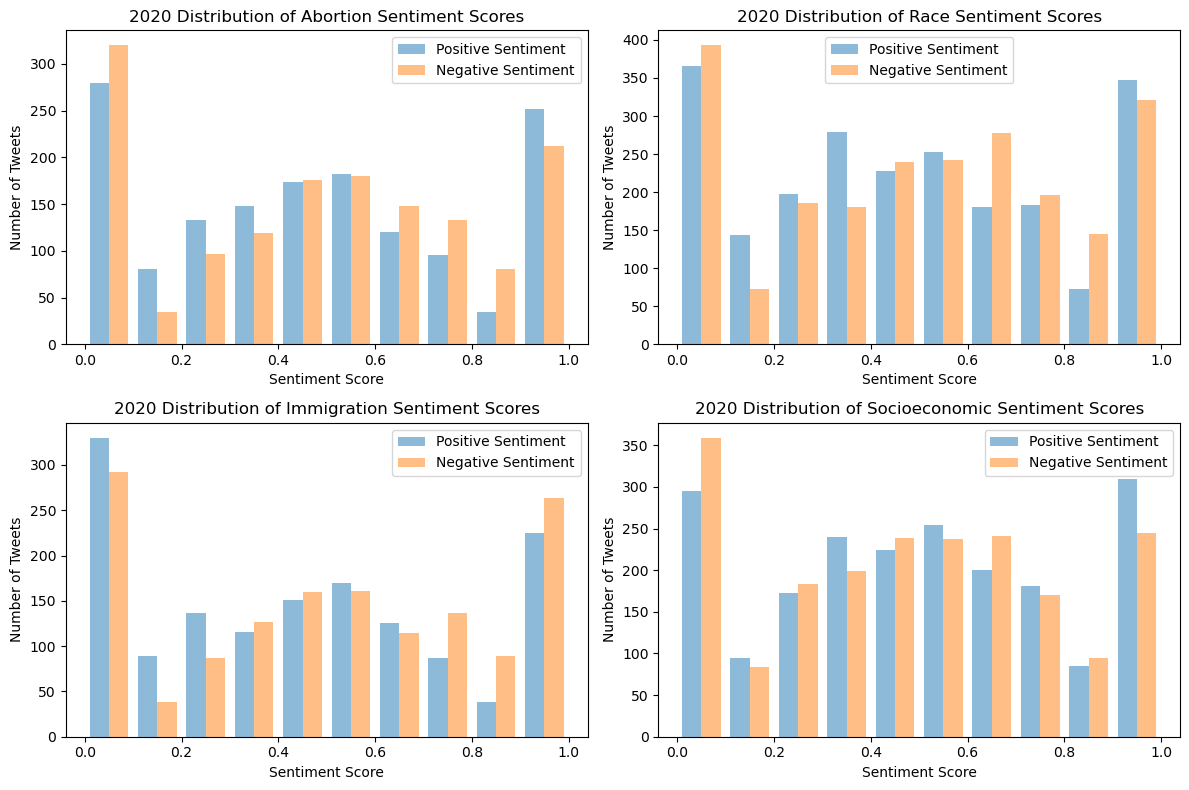

In [32]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot histogram for abortion sentiment
axes[0, 0].hist([abortion_sent_2020['Norm_Pos'], abortion_sent_2020['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[0, 0].set_xlabel('Sentiment Score')
axes[0, 0].set_ylabel('Number of Tweets')
axes[0, 0].set_title('2020 Distribution of Abortion Sentiment Scores')
axes[0, 0].legend()

# Plot histogram for race sentiment
axes[0, 1].hist([race_sent_2020['Norm_Pos'], race_sent_2020['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[0, 1].set_xlabel('Sentiment Score')
axes[0, 1].set_ylabel('Number of Tweets')
axes[0, 1].set_title('2020 Distribution of Race Sentiment Scores')
axes[0, 1].legend()

# Plot histogram for immigration sentiment
axes[1, 0].hist([immigration_sent_2020['Norm_Pos'], immigration_sent_2020['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[1, 0].set_xlabel('Sentiment Score')
axes[1, 0].set_ylabel('Number of Tweets')
axes[1, 0].set_title('2020 Distribution of Immigration Sentiment Scores')
axes[1, 0].legend()

# Plot histogram for socioeconomic sentiment
axes[1, 1].hist([socio_sent_2020['Norm_Pos'], socio_sent_2020['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[1, 1].set_xlabel('Sentiment Score')
axes[1, 1].set_ylabel('Number of Tweets')
axes[1, 1].set_title('2020 Distribution of Socioeconomic Sentiment Scores')
axes[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Creating one table with all Bias group tags

In [33]:
data_2020
# gives 9824 rows × 9 columns

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...,NaN,matter,NaN,NaN
1,2020,2020-08-01 03:29:02.0,TX,763513801874419712,itsjefftiedrich realdonaldtrump please continu...,NaN,NaN,NaN,NaN
2,2020,2020-08-01 06:39:15.0,TX,1153704213236633602,donny just blow test be do all over he dumbass...,NaN,NaN,NaN,NaN
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...,NaN,NaN,NaN,economic
4,2020,2020-08-01 15:24:36.0,KY,1114258326068629505,all the drive up corona test and we arent smar...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
14055,2020,2020-11-30 14:13:19.0,IL,801059546886180864,itsjefftiedrich realdonaldtrump trump do not l...,NaN,NaN,NaN,NaN
14057,2020,2020-11-30 18:19:42.0,OR,2711106523,knighth53596 itsjefftiedrich realdonaldtrump o...,NaN,NaN,NaN,NaN
14058,2020,2020-11-30 19:46:15.0,WA,1350342876,neville1776 kingstonerj faiithe onesynical ell...,NaN,NaN,NaN,NaN
14060,2020,2020-11-30 22:45:58.0,MN,3244707002,trump pressure senator governor and rep to pus...,NaN,NaN,NaN,middle


In [34]:
# Remove rows with all NaN values in 'Abortion', 'Race', 'Immigration', and 'Socio_Eco' columns
data_2020_filtered = data_2020.dropna(subset=['Abortion', 'Race', 'Immigration', 'Socio_Eco'], how='all')

# Display the filtered DataFrame
print(data_2020_filtered)
# gives [5386 rows x 9 columns]

       Year                Created State                Owner   
0      2020  2020-08-01 00:19:13.0    OR  1033162882471477248  \
3      2020  2020-08-01 14:19:56.0    OK           4805323446   
5      2020  2020-08-01 16:05:37.0    KY  1114258326068629505   
6      2020  2020-08-01 19:06:56.0    CA           2476183298   
8      2020  2020-08-02 04:21:24.0    AZ  1247976786039721991   
...     ...                    ...   ...                  ...   
14045  2020  2020-11-29 22:32:28.0    IL           1855713859   
14046  2020  2020-11-30 00:46:33.0    MI  1230154091176878082   
14050  2020  2020-11-30 03:27:36.0    MD             79052264   
14051  2020  2020-11-30 05:16:11.0    FL           2595264354   
14060  2020  2020-11-30 22:45:58.0    MN           3244707002   

                                                   Tweet Abortion     Race   
0      not to worry he already demonstrate he not sma...      NaN   matter  \
3      southernwayjim dineshdsouza usa 8year march to...      N

In [35]:
# run Vader sentiment on All tweets
data_sent_2020 = get_sentiment_scores(data_2020_filtered)
data_sent_2020
# gives [5386 rows x 9 columns]

C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\3555041138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\3555041138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,SentimentScores
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...,NaN,matter,NaN,NaN,"{'neg': 0.122, 'pos': 0.108}"
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...,NaN,NaN,NaN,economic,"{'neg': 0.166, 'pos': 0.053}"
5,2020,2020-08-01 16:05:37.0,KY,1114258326068629505,willie7wlw richd7665685 therealjeffruby realdo...,debate,NaN,NaN,NaN,"{'neg': 0.05, 'pos': 0.0}"
6,2020,2020-08-01 19:06:56.0,CA,2476183298,dylanbrody jerilryan a chess player would have...,NaN,NaN,border,NaN,"{'neg': 0.088, 'pos': 0.072}"
8,2020,2020-08-02 04:21:24.0,AZ,1247976786039721991,please explain to me why trump close the china...,NaN,NaN,border,NaN,"{'neg': 0.274, 'pos': 0.028}"
...,...,...,...,...,...,...,...,...,...,...
14045,2020,2020-11-29 22:32:28.0,IL,1855713859,thehill every move trump be try to make i pred...,NaN,NaN,NaN,line,"{'neg': 0.268, 'pos': 0.111}"
14046,2020,2020-11-30 00:46:33.0,MI,1230154091176878082,davidntenn221 jonathanturley lilrichie42 reald...,NaN,NaN,family,NaN,"{'neg': 0.052, 'pos': 0.056}"
14050,2020,2020-11-30 03:27:36.0,MD,79052264,jasonboyte roy4 richard22476 fredloveflpi dpwi...,NaN,matter,NaN,NaN,"{'neg': 0.057, 'pos': 0.231}"
14051,2020,2020-11-30 05:16:11.0,FL,2595264354,marklevinshow mark i agree and i be really ang...,NaN,justice,NaN,justice,"{'neg': 0.258, 'pos': 0.298}"


In [36]:
# Extract the sentiment scores from the 'SentimentScores' column
data_sent_2020['Norm_Neg'] = data_sent_2020['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
data_sent_2020['Norm_Pos'] = data_sent_2020['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
data_sent_2020
# gives [5386 rows x 9 columns]

C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\2033182442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sent_2020['Norm_Neg'] = data_sent_2020['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\2033182442.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sent_2020['Norm_Pos'] = data_sent_2020['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos'])

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,SentimentScores,Norm_Neg,Norm_Pos
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...,NaN,matter,NaN,NaN,"{'neg': 0.122, 'pos': 0.108}",0.530435,0.469565
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...,NaN,NaN,NaN,economic,"{'neg': 0.166, 'pos': 0.053}",0.757991,0.242009
5,2020,2020-08-01 16:05:37.0,KY,1114258326068629505,willie7wlw richd7665685 therealjeffruby realdo...,debate,NaN,NaN,NaN,"{'neg': 0.05, 'pos': 0.0}",1.000000,0.000000
6,2020,2020-08-01 19:06:56.0,CA,2476183298,dylanbrody jerilryan a chess player would have...,NaN,NaN,border,NaN,"{'neg': 0.088, 'pos': 0.072}",0.550000,0.450000
8,2020,2020-08-02 04:21:24.0,AZ,1247976786039721991,please explain to me why trump close the china...,NaN,NaN,border,NaN,"{'neg': 0.274, 'pos': 0.028}",0.907285,0.092715
...,...,...,...,...,...,...,...,...,...,...,...,...
14045,2020,2020-11-29 22:32:28.0,IL,1855713859,thehill every move trump be try to make i pred...,NaN,NaN,NaN,line,"{'neg': 0.268, 'pos': 0.111}",0.707124,0.292876
14046,2020,2020-11-30 00:46:33.0,MI,1230154091176878082,davidntenn221 jonathanturley lilrichie42 reald...,NaN,NaN,family,NaN,"{'neg': 0.052, 'pos': 0.056}",0.481481,0.518519
14050,2020,2020-11-30 03:27:36.0,MD,79052264,jasonboyte roy4 richard22476 fredloveflpi dpwi...,NaN,matter,NaN,NaN,"{'neg': 0.057, 'pos': 0.231}",0.197917,0.802083
14051,2020,2020-11-30 05:16:11.0,FL,2595264354,marklevinshow mark i agree and i be really ang...,NaN,justice,NaN,justice,"{'neg': 0.258, 'pos': 0.298}",0.464029,0.535971


In [37]:
# This function only gets the compound sentiment
def get_compound_sentiment(df):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
        # Create a new column for sentiment scores
    df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
    
    # Remove the 'neu' column from the SentimentScores column
    df['Compound'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu','pos','neg']})
    
    return df

In [38]:
# run Vader sentiment on All tweets
data_all_sent_2020 = get_compound_sentiment(data_2020_filtered)
# Drop Sentiment Scores column
data_all_sent_2020 = data_all_sent_2020.drop(['SentimentScores'], axis=1)
data_all_sent_2020
# gives [5386 rows x 9 columns]

C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\406677615.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\406677615.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Compound'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu','pos','neg']})


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,Norm_Neg,Norm_Pos,Compound
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...,NaN,matter,NaN,NaN,0.530435,0.469565,{'compound': -0.4082}
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...,NaN,NaN,NaN,economic,0.757991,0.242009,{'compound': -0.6705}
5,2020,2020-08-01 16:05:37.0,KY,1114258326068629505,willie7wlw richd7665685 therealjeffruby realdo...,debate,NaN,NaN,NaN,1.000000,0.000000,{'compound': -0.2732}
6,2020,2020-08-01 19:06:56.0,CA,2476183298,dylanbrody jerilryan a chess player would have...,NaN,NaN,border,NaN,0.550000,0.450000,{'compound': -0.4043}
8,2020,2020-08-02 04:21:24.0,AZ,1247976786039721991,please explain to me why trump close the china...,NaN,NaN,border,NaN,0.907285,0.092715,{'compound': -0.9377}
...,...,...,...,...,...,...,...,...,...,...,...,...
14045,2020,2020-11-29 22:32:28.0,IL,1855713859,thehill every move trump be try to make i pred...,NaN,NaN,NaN,line,0.707124,0.292876,{'compound': -0.8847}
14046,2020,2020-11-30 00:46:33.0,MI,1230154091176878082,davidntenn221 jonathanturley lilrichie42 reald...,NaN,NaN,family,NaN,0.481481,0.518519,{'compound': 0.0444}
14050,2020,2020-11-30 03:27:36.0,MD,79052264,jasonboyte roy4 richard22476 fredloveflpi dpwi...,NaN,matter,NaN,NaN,0.197917,0.802083,{'compound': 0.8402}
14051,2020,2020-11-30 05:16:11.0,FL,2595264354,marklevinshow mark i agree and i be really ang...,NaN,justice,NaN,justice,0.464029,0.535971,{'compound': 0.2116}


## Final correct data frame to upload to postgresSQL

In [39]:
# Extract to compound value from the dictionary

# Update the "Compound" column
data_all_sent_2020['Compound'] = data_all_sent_2020['Compound'].apply(lambda x: x['compound'])

# Convert the "Compound" column to a numeric data type
data_all_sent_2020['Compound'] = pd.to_numeric(data_all_sent_2020['Compound'])

# Print the updated DataFrame
data_all_sent_2020
# gives [5386 rows x 9 columns]

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,Norm_Neg,Norm_Pos,Compound
0,2020,2020-08-01 00:19:13.0,OR,1033162882471477248,not to worry he already demonstrate he not sma...,NaN,matter,NaN,NaN,0.530435,0.469565,-0.4082
3,2020,2020-08-01 14:19:56.0,OK,4805323446,southernwayjim dineshdsouza usa 8year march to...,NaN,NaN,NaN,economic,0.757991,0.242009,-0.6705
5,2020,2020-08-01 16:05:37.0,KY,1114258326068629505,willie7wlw richd7665685 therealjeffruby realdo...,debate,NaN,NaN,NaN,1.000000,0.000000,-0.2732
6,2020,2020-08-01 19:06:56.0,CA,2476183298,dylanbrody jerilryan a chess player would have...,NaN,NaN,border,NaN,0.550000,0.450000,-0.4043
8,2020,2020-08-02 04:21:24.0,AZ,1247976786039721991,please explain to me why trump close the china...,NaN,NaN,border,NaN,0.907285,0.092715,-0.9377
...,...,...,...,...,...,...,...,...,...,...,...,...
14045,2020,2020-11-29 22:32:28.0,IL,1855713859,thehill every move trump be try to make i pred...,NaN,NaN,NaN,line,0.707124,0.292876,-0.8847
14046,2020,2020-11-30 00:46:33.0,MI,1230154091176878082,davidntenn221 jonathanturley lilrichie42 reald...,NaN,NaN,family,NaN,0.481481,0.518519,0.0444
14050,2020,2020-11-30 03:27:36.0,MD,79052264,jasonboyte roy4 richard22476 fredloveflpi dpwi...,NaN,matter,NaN,NaN,0.197917,0.802083,0.8402
14051,2020,2020-11-30 05:16:11.0,FL,2595264354,marklevinshow mark i agree and i be really ang...,NaN,justice,NaN,justice,0.464029,0.535971,0.2116


## Load Sentiment table into PostGres
data_all_sent_2017: The single table that has all data

In [40]:
# Replace the values below with your database credentials
DATABASE = "sentimentdb"
USER = "postgres"
PASSWORD = "YourPassword"
HOST = "localhost"
PORT = "5432"

# Connect to your PostgreSQL database
conn = psycopg2.connect(
    database=DATABASE,
    user=USER,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

# Create a sqlalchemy engine
engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}")

data_all_sent_2020.to_sql("twitter", engine, if_exists="append", index=False)
print("Twitter table loaded successfully")

# Commit the changes to the database
conn.commit()

# Close the database connection
conn.close()

Twitter table loaded successfully


## View the data

In [41]:
# Replace the values below with your database credentials
DATABASE = "sentimentdb"
USER = "postgres"
PASSWORD = "YourPassword"
HOST = "localhost"
PORT = "5432"

# Connect to the PostgreSQL database
conn = psycopg2.connect(database=DATABASE, user=USER, password=PASSWORD, host=HOST, port=PORT)

# Query the table and store the results in a Pandas dataframe
df = pd.read_sql_query("SELECT * FROM twitter", conn)

# Print the dataframe to verify that it contains data
print(df)

# Close the database connection
conn.close()
# gives [3164 rows x 12 columns] for 2016
# [5103 rows x 12 columns] for 2017 appended = 1938
# [11304 rows x 12 columns] for 2018 appended = 6201
# [16485 rows x 12 columns] for 2019 appended = 5186
# [21871 rows x 12 columns] for 2020 appended = 5386

       Year                Created State                Owner   
0      2016    2016-01-03 10:33:49    TX             14649308  \
1      2016    2016-01-04 16:23:26    NH             88940328   
2      2016     2016-01-05 7:13:04    VA            359716229   
3      2016     2016-01-06 2:52:22    AZ             67238855   
4      2016    2016-01-06 15:27:19    NY             49698134   
...     ...                    ...   ...                  ...   
21866  2020  2020-11-29 22:32:28.0    IL           1855713859   
21867  2020  2020-11-30 00:46:33.0    MI  1230154091176878082   
21868  2020  2020-11-30 03:27:36.0    MD             79052264   
21869  2020  2020-11-30 05:16:11.0    FL           2595264354   
21870  2020  2020-11-30 22:45:58.0    MN           3244707002   

                                                   Tweet  Abortion     Race   
0      deep convos after midtown about black life mat...      None    black  \
1      president bill clinton say this election will ...     

C:\Users\Owner\AppData\Local\Temp\ipykernel_15968\688198546.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM twitter", conn)
